# Exploratory Data Analysis

This notebook provides an overview of the data used, analysis and visualisation of the signals.

The signals used were recorded with Trace earlobe-worn device during active stand-up and sit-up tests. The signals captured are photoplethysmography (PPG) and accelerometer (ACC). Heart rate (HR) was extracted from the PPG signal. All of the signals were recorded with the sampling rate of 50 Hz.

Developers of the Trace device are using a special private module to preprocess the signals and extract HR. The signals presented below are the ones after the preprocessing.

### Data loading

In [1]:
import json

fs = 50
with open('data/DATA.json', 'r') as openfile:
    DATA = json.load(openfile)
    
print(f"Total number of signals: {len(DATA['targets'])}")

Total number of signals: 212


## Data visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

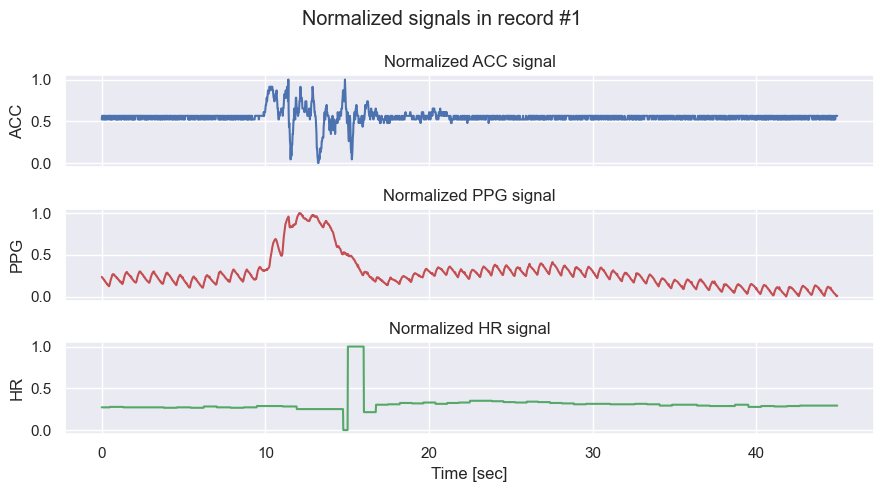

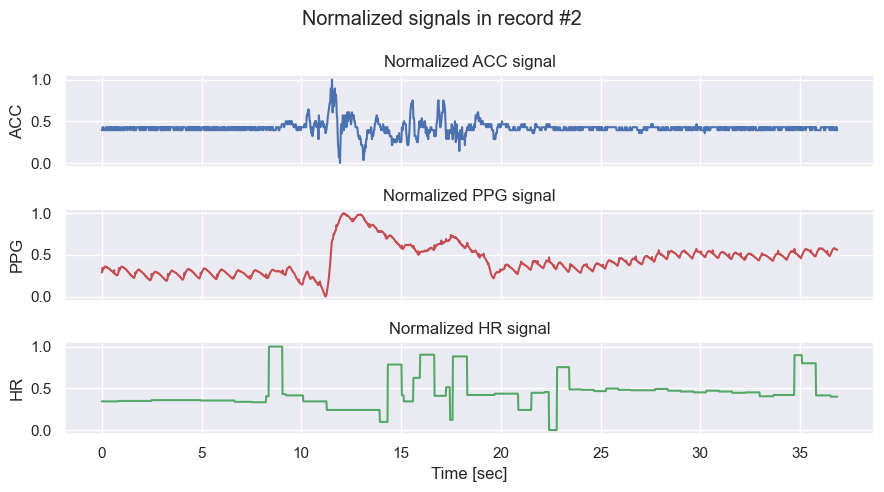

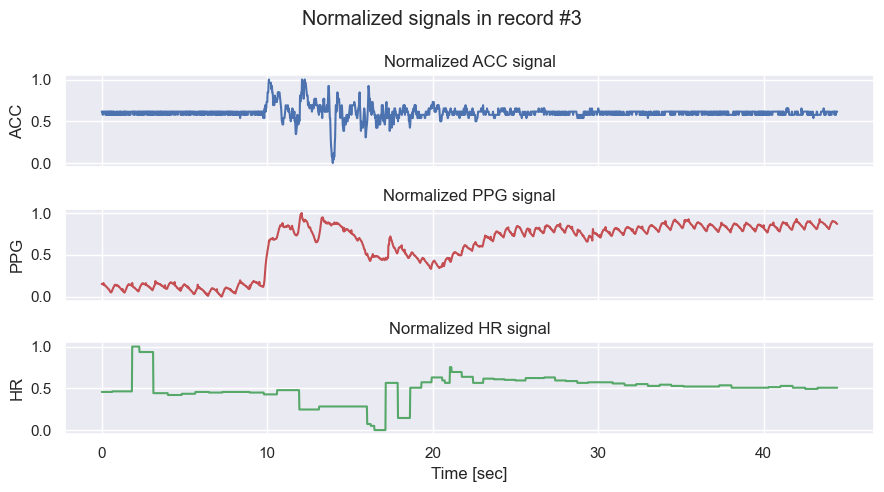

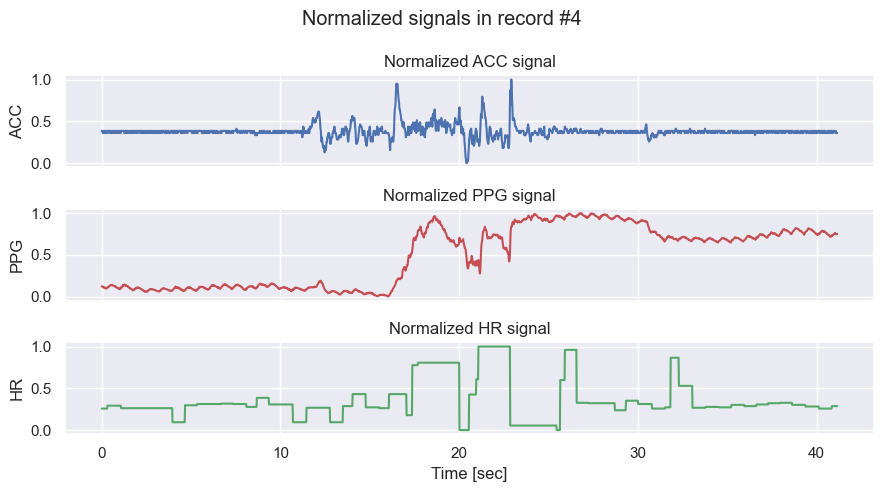

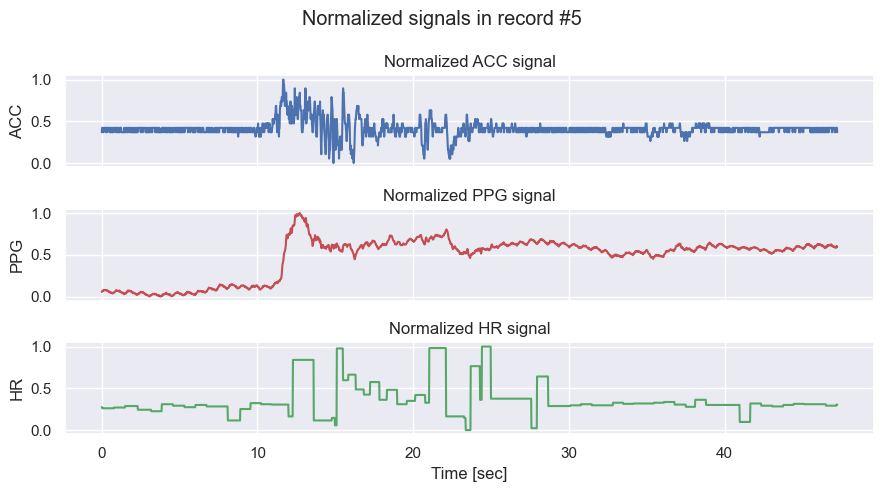

In [3]:
records_to_show = 5

for i in range(records_to_show):
    acc, ppg, hr = DATA['accelerometer_data'][i], DATA['ppg_data'][i], DATA['hr_data'][i]
    
    ts = np.arange(len(acc)) / fs
    fig, axs = plt.subplots(nrows=3, figsize=(9, 5), sharex=True)
    
    axs[0].plot(ts, acc, color='b')
    axs[0].set_ylabel('ACC')
    axs[0].set_title('Normalized ACC signal')
    
    axs[1].plot(ts, ppg, color='r')
    axs[1].set_ylabel('PPG')
    axs[1].set_title('Normalized PPG signal')
    
    axs[2].plot(ts, hr, color='g')
    axs[2].set_ylabel('HR')
    axs[2].set_title('Normalized HR signal')
    
    plt.xlabel('Time [sec]')
    fig.suptitle(f'Normalized signals in record #{i + 1}')
    plt.tight_layout()
    plt.show()
    
    

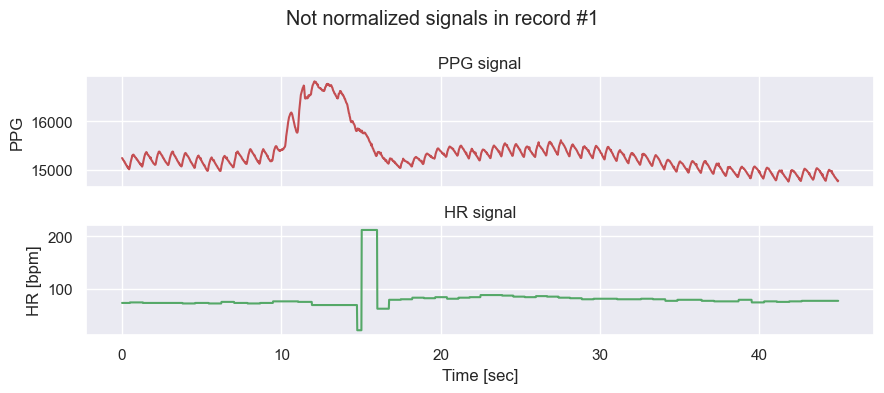

In [4]:
records_to_show = 1

for i in range(records_to_show):
    ppg, hr = DATA['ppg_not_normalized'][i], DATA['hr_not_normalized'][i]
    
    ts = np.arange(len(ppg)) / fs
    fig, axs = plt.subplots(nrows=2, figsize=(9, 4), sharex=True)
    
    axs[0].plot(ts, ppg, color='r')
    axs[0].set_ylabel('PPG')
    axs[0].set_title('PPG signal')
    
    axs[1].plot(ts, hr, color='g')
    axs[1].set_ylabel('HR [bpm]')
    axs[1].set_title('HR signal')
    
    plt.xlabel('Time [sec]')
    fig.suptitle(f'Not normalized signals in record #{i + 1}')
    plt.tight_layout()
    plt.show()


### Signals with stages

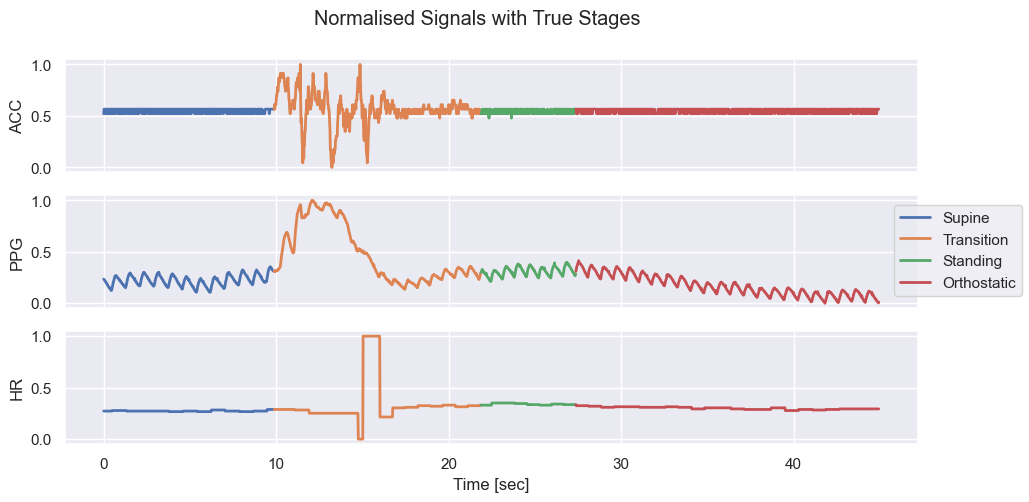

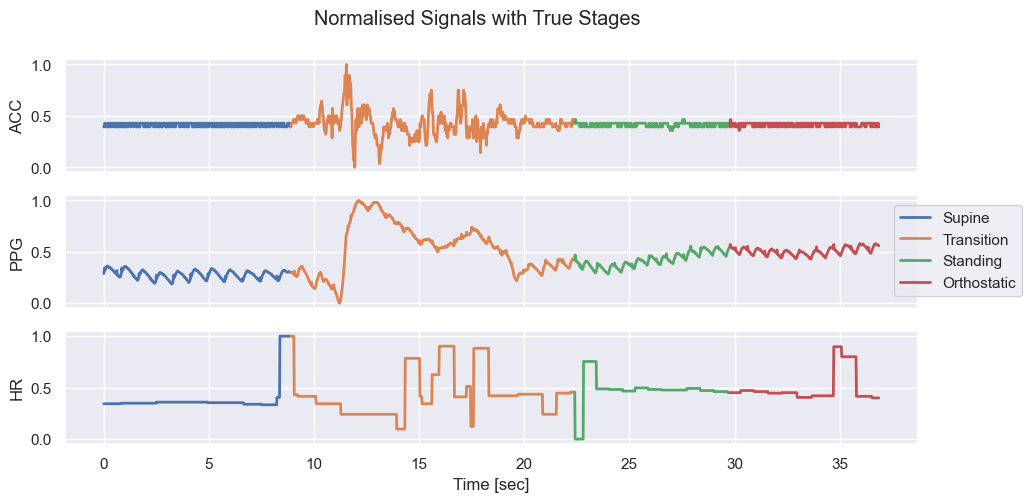

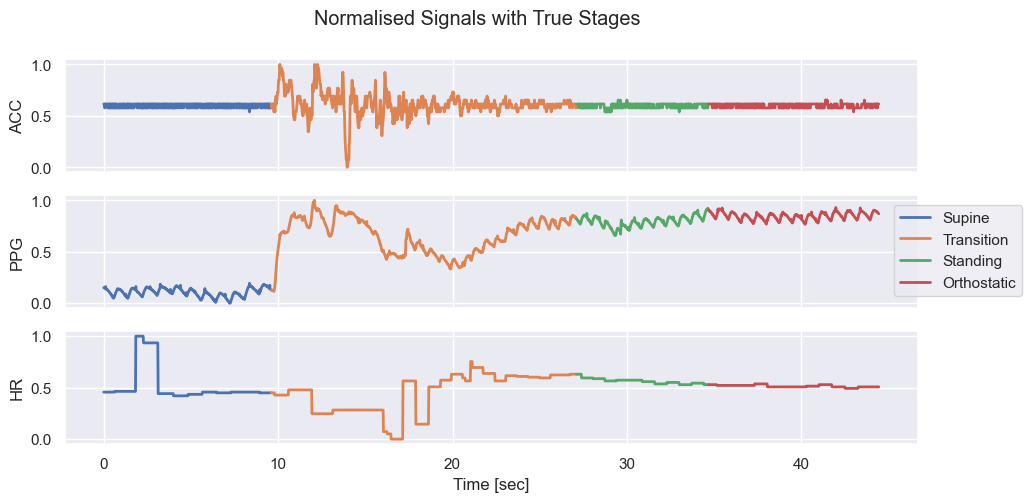

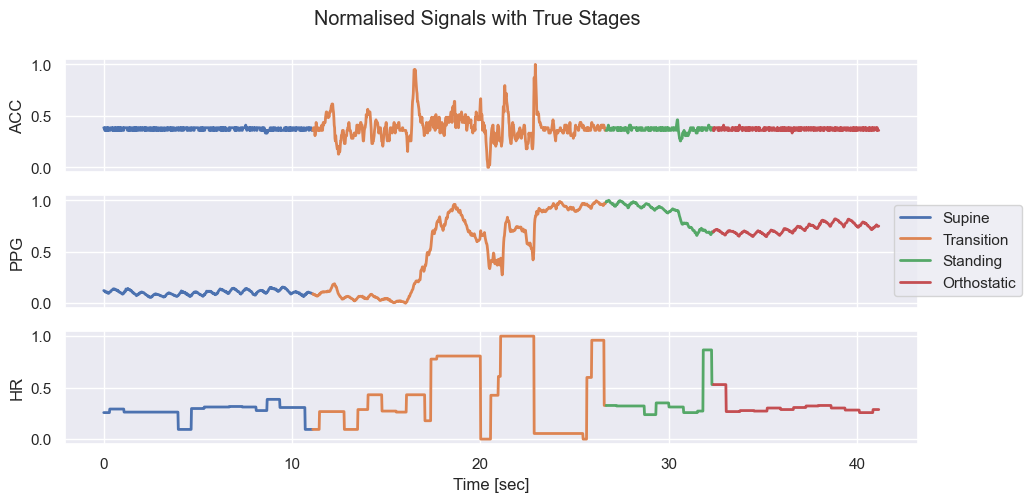

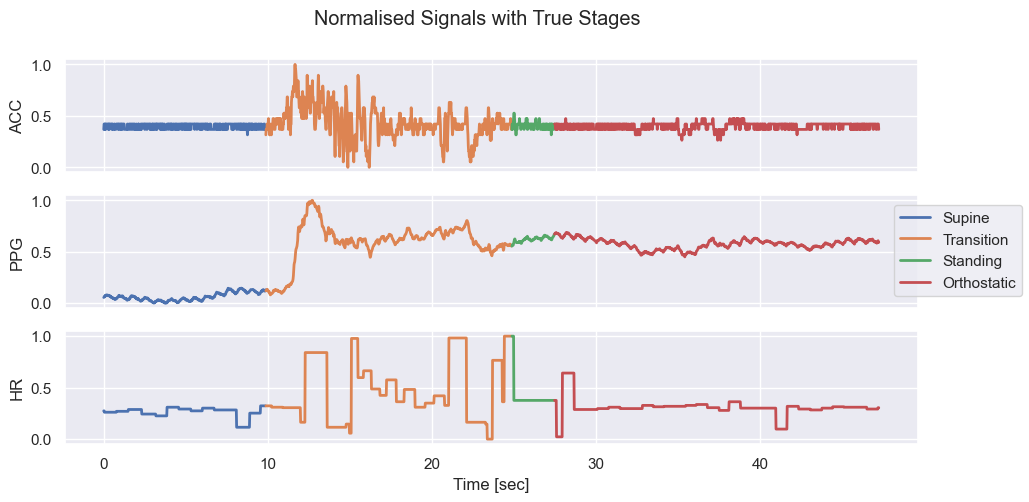

In [5]:
colors = sns.color_palette()
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']

records_to_show = 5

for i in range(records_to_show):
    
    fig, axs = plt.subplots(nrows=3, figsize=(11, 5), sharex=True)
    acc, ppg, hr = DATA['accelerometer_data'][i], DATA['ppg_data'][i], DATA['hr_data'][i]
    for feature_num, feature in enumerate([acc, ppg, hr]):
        ts = np.arange(len(feature)) / fs

        last_label = DATA['targets'][i][0]
        last_index = 0
        for j in range(1, len(feature)):
            if DATA['targets'][i][j] != last_label:
                label = labels_names[last_label]
                axs[feature_num].plot(ts[last_index: j], feature[last_index: j],
                                      color=colors[last_label], label=label, linewidth=2)
                last_label = DATA['targets'][i][j]
                last_index = j
                
        label = labels_names[last_label]
        axs[feature_num].plot(ts[last_index:], feature[last_index:],
                              color=colors[last_label], label=label, linewidth=2)

    handles, legend_labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(legend_labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center right')
    fig.suptitle('Normalised Signals with True Stages')
    
    axs[0].set_ylabel('ACC')
    axs[1].set_ylabel('PPG')
    axs[2].set_ylabel('HR')
    plt.xlabel('Time [sec]')
    
    plt.show()



### Dataset balance

In [6]:
class_counts = np.bincount(np.concatenate(DATA['targets']).ravel())
class_weights = class_counts / len(np.concatenate(DATA['targets']).ravel())

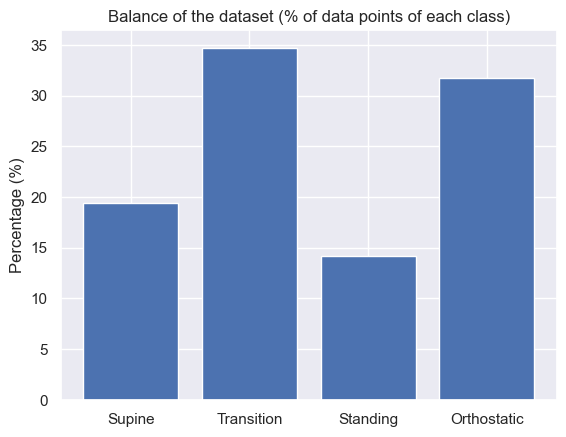

In [7]:
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']
plt.bar(labels_names, class_weights * 100)
plt.title('Balance of the dataset (% of data points of each class)')
plt.ylabel('Percentage (%)')
plt.show()

## Biometrics analysis

In [8]:
import pandas as pd

def calculate_ohv1(signals_for_biometrics):
    ohv1_array = []
    for i in range(len(signals_for_biometrics['ppg_not_normalized'])):
        current_ppg, current_targets = np.array(signals_for_biometrics['ppg_not_normalized'][i]), np.array(signals_for_biometrics['targets'][i])
        mask = np.where(current_targets == 0)
        min_supine = min(current_ppg[mask])
        try:
            mask = np.where(current_targets == 2)
            min_standing = min(current_ppg[mask])
        except ValueError:
            # sometimes there is no standing stage, since the PPG reached orthostatis after transition
            min_standing = signals_for_biometrics['targets'][i].index(3)
            end_transition = signals_for_biometrics['targets'][i].index(3)
            min_standing = current_ppg[end_transition]
        ohv1 = abs(min_standing - min_supine)
        ohv1_array.append(ohv1)

    return pd.Series(ohv1_array)


def calculate_ohv2(signals_for_biometrics):
    ohv2_array = []
    for i in range(len(signals_for_biometrics['ppg_not_normalized'])):
        current_ppg, current_targets = np.array(signals_for_biometrics['ppg_not_normalized'][i]), np.array(signals_for_biometrics['targets'][i])

        mask = np.where(current_targets == 0)
        min_supine = min(current_ppg[mask])
        mask = np.where(current_targets == 3)
        min_orthos = min(current_ppg[mask])
        ohv2 = abs(min_orthos - min_supine)
        ohv2_array.append(ohv2)

    return pd.Series(ohv2_array)


def calculate_otc(signals_for_biometrics):
    otc_array = []
    
    for i in range(len(signals_for_biometrics['targets'])):
        current_targets = signals_for_biometrics['targets'][i]
        start_transition = current_targets.index(1)
        orthostatis_archieved_at = current_targets.index(3)
        otc = abs(orthostatis_archieved_at - start_transition) / fs
        otc_array.append(otc)
    
    return pd.Series(otc_array)

def calculate_pot(signals_for_biometrics):
    pot_array = []
    for i in range(len(signals_for_biometrics['hr_not_normalized'])):
        current_hr, current_targets = np.array(signals_for_biometrics['hr_not_normalized'][i]), np.array(signals_for_biometrics['targets'][i])

        mask = np.where(current_targets == 0)
        avg_supine = np.mean(current_hr[mask])
        mask = np.where((current_targets == 1) | (current_targets == 2))
        max_standing_orthostatis = max(current_hr[mask])
        pot = abs(max_standing_orthostatis - avg_supine)
        pot_array.append(pot)

    return pd.Series(pot_array)


### OHV1

In [9]:
ohv1 = calculate_ohv1(DATA)
summary = ohv1.describe()
print('---- OHV1 metric characteristics ----', summary, sep='\n')

---- OHV1 metric characteristics ----
count      212.000000
mean       978.216981
std       1366.949407
min          2.000000
25%        277.250000
50%        588.000000
75%       1129.250000
max      14555.000000
dtype: float64


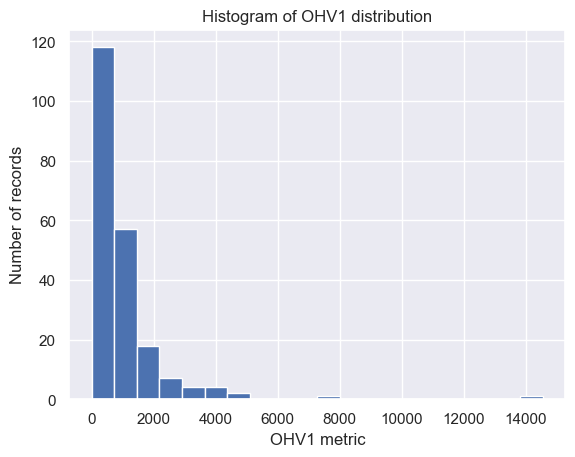

In [10]:
plt.hist(ohv1, 20)
plt.xlabel('OHV1 metric')
plt.ylabel('Number of records')
plt.title('Histogram of OHV1 distribution')
plt.show()

### OHV2

In [11]:
ohv2 = calculate_ohv2(DATA)
summary = ohv2.describe()
print('---- OHV2 metric characteristics ----', summary, sep='\n')

---- OHV2 metric characteristics ----
count      212.000000
mean      1042.773585
std       1508.629907
min          1.000000
25%        272.000000
50%        678.500000
75%       1288.500000
max      16116.000000
dtype: float64


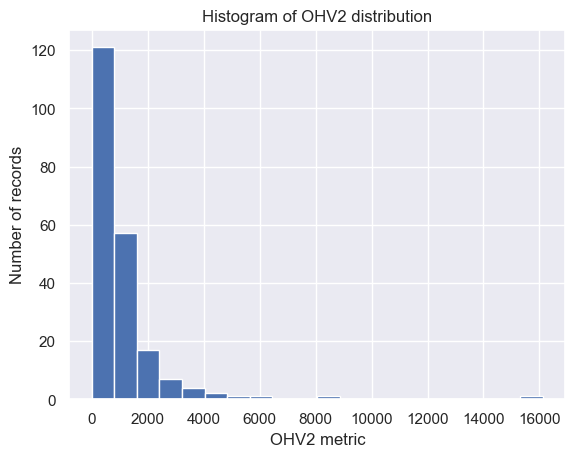

In [12]:
plt.hist(ohv2, 20)
plt.xlabel('OHV2 metric')
plt.ylabel('Number of records')
plt.title('Histogram of OHV2 distribution')
plt.show()

### OTC

In [13]:
otc = calculate_otc(DATA)
summary = otc.describe()
print('---- OTC metric characteristics ----', summary, sep='\n')

---- OTC metric characteristics ----
count    212.000000
mean      26.360189
std       18.265205
min        6.580000
25%       17.475000
50%       22.340000
75%       30.000000
max      202.440000
dtype: float64


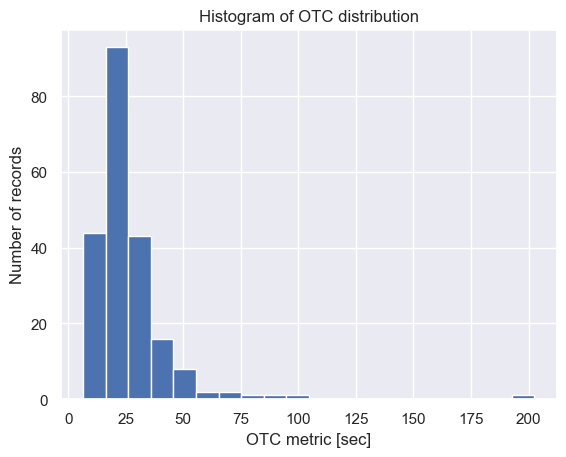

In [14]:
plt.hist(otc, 20)
plt.xlabel('OTC metric [sec]')
plt.ylabel('Number of records')
plt.title('Histogram of OTC distribution')
plt.show()

### POT

In [15]:
pot = calculate_pot(DATA)
summary = pot.describe()
print('---- POT metric characteristics ----', summary, sep='\n')

---- POT metric characteristics ----
count    212.000000
mean      90.156211
std       57.352081
min        6.908108
25%       32.245376
50%       97.107533
75%      142.402962
max      193.000000
dtype: float64


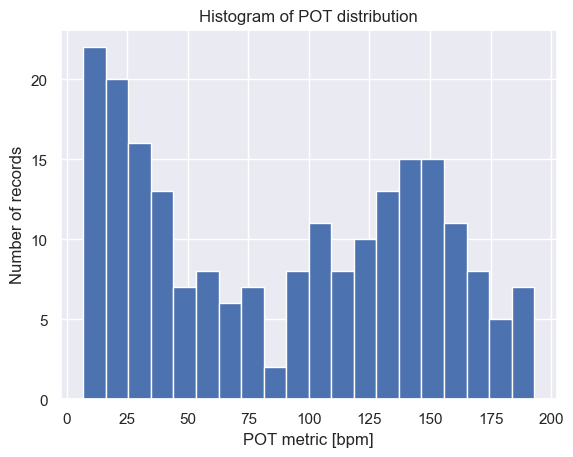

In [16]:
plt.hist(pot, 20)
plt.xlabel('POT metric [bpm]')
plt.ylabel('Number of records')
plt.title('Histogram of POT distribution')
plt.show()